Lisez bien la documentation de la classe Node2vec du PyG, et répondez aux questions suivantes :
Lien vers la documentation : https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=Node2vec#torch_geometric.nn.models.Node2Vec



* **Quelle est la différence entre le paramètre walk_length et context_size ?**

walk_length : C'est la longueur totale de chaque marche aléatoire générée depuis un nœud de départ. Autrement dit, si walk_length = L, alors pour chaque nœud de départ on va créer une séquence (un « chemin ») de L nœuds (en comptant le nœud de départ) en suivant la stratégie de transition biaisée de Node2Vec.

context_size : C'est la taille de la fenêtre de contexte considérée autour de chaque nœud cible lorsque l'on forme les paires positives (pour l'objectif Skip-Gram).
Selon la doc PyG : « If set to i, we are interested in i-1 neighbors on each side of a target node. »
Donc si context_size = i, pour chaque nœud dans la marche, on va former des paires positives avec jusqu'à (i-1)(i-1) voisins en amont et (i-1)(i-1) voisins en aval dans la marche.

* **Soit M une marche aléatoire M={ u,s1,s2,s4,s5,s6} , et supposant que context_size = 3, combien d'échantillons positifs peut-on générer de cette marche ?**

On a ici 6 nœuds dans la marche (indices 0 à 5). Avec context_size = 3, cela signifie que, pour chaque nœud cible, on considère jusqu'à 2 voisins à gauche et 2 voisins à droite (lorsqu'ils existent).

Pour compter le nombre total de paires positives (target, context) :

* Indice 0 → nœud u : on peut prendre au plus 2 voisins à droite (car à gauche on est en début de séquence). Les voisins valides sont s1,s2 ⇒ 2 paires positives.
* Indice 1 → nœud s1 : voisins (à gauche) : u, (à droite) : s2,s4 ⇒ 3 paires positives.
* Indice 2 → nœud s2 : voisins (à gauche) : u,s1 (à droite) : s4,s5 ⇒ 4 paires positives.
* Indice 3 → nœud s4 : voisins (à gauche) : s1,s2 (à droite) : s5,s6 ⇒ 4 paires positives.
* Indice 4 →→ nœud s5s5 : voisins (à gauche) : s2,s4s2,s4, (à droite) : s6 ⇒ 3 paires positives.
* Indice 5 → nœud s6 : voisins (à gauche) : s4,s5 (à droite) : aucun ⇒ 2 paires positives.

En additionnant on obtient :
2 + 3 + 4 + 4 + 3 + 2 = 18.

Donc on génère **18 échantillons positifs** à partir de cette unique marche aléatoire.


* **À quoi sert le paramètre num_negative_samples ?**

Dans l'approche Skip-Gram avec négative sampling, pour chaque paire (target, context) jugée « positive », on va échantillonner un certain nombre de « faux contextes » (les échantillons négatifs) afin de mieux approximer le terme de normalisation dans la fonction de perte.

Le paramètre num_negative_samples indique combien de nœuds négatifs (non voisins) on génère par échantillon positif pour effectuer le negative sampling.

*	**Comment sont générées les marches négatives ?**

Dans le cadre du « negative sampling » (échantillonnage négatif) :

* On va tirer aléatoirement (selon une certaine distribution, souvent uniforme ou proportionnelle au degré des nœuds) un ou plusieurs nœuds du graphe pour chaque paire positive, afin de constituer de fausses paires (target,noeud_aleatoire)(target,noeud_aleatoire).
* Ces paires sont considérées « négatives » car on suppose que ces nœuds aléatoires n'apparaissent pas dans le contexte immédiat du nœud cible dans la marche réelle.

*	**Que retourne le  loader de Node2vec ?**

Lorsque l'on crée un loader = Node2VecLoader(...) ou qu'on appelle la méthode loader.sample(), on obtient (par batch) :

* pos_rw : un tenseur contenant les marches positives (les vrais contextes).
* neg_rw : un tenseur contenant les marches négatives (les contextes négatifs) générées par échantillonnage aléatoire.

Autrement dit, à chaque itération du loader (ou appel de sample()), on récupère un lot (batch) de paires (positives, négatives) prêtes à être passées dans la fonction de perte Node2Vec (Skip-Gram + Negative Sampling), ce qui permet d'entraîner les embeddings de nœuds.


# Classification des noeuds avec Node2vec

Dans cet exemple, nous allons utilisé la bibliothéque PyG. PyG (PyTorch Geometric) est une bibliothèque basée sur PyTorch pour écrire et modeliser facilement des réseaux de neurones sur les graphes (GNN) pour un large éventail d'applications liées aux données de type graphe.

Cette bibliothéque se compose de diverses méthodes d'apprentissage profond sur les graphes, également appelées méthodes  d'apprentissage profond géométriques, à partir d'une variété d'articles publiés.

Installation : Suivre les etapes du fichier requirements.txt

Documentation :  https://pytorch-geometric.readthedocs.io/en/latest/


In [1]:
%pip install networkx
%pip install numpy
%pip install matplotlib
%pip install torch
%pip install scikit-learn
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
%pip install git+https://github.com/pyg-team/pytorch_geometric.git
%pip install ogb

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 24.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-zlvrpg5s
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-zlvrpg5s
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9bffcd470057f2f865aedb87815267c243806e13
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1172888 sha256=f237725b0180dde9a25e37c7baa79af1506a

## Le réseau CORA

Le graphe CORA est un réseau de citations contenant 2708 noeuds représentant des publications scientifiques classées en 7 classes et 5429 arêtes.

In [2]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

Processing...
Done!


## Question 1 :
Transformez le dataset en graphe networkx et visualisez le graphe : les noeuds doivent etre colorés selon leur classe d'appartenance.

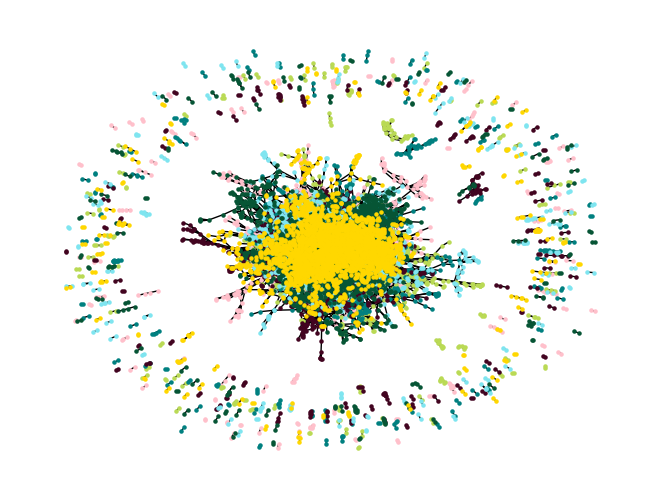

In [4]:
import networkx as nx

########################Votre code ici ##############################
# à faire : Créer le graphe networkx à partir de la liste des arêtes
G = nx.Graph()
edges = data.edge_index.t().tolist()  # Transforme edge_index en liste d'arêtes
G.add_edges_from(edges)

# à faire : Remplir les listes des 7 classes
# utilisez data.y qui contient les classes
Classes = [[] for _ in range(7)]  # Initialisation des listes pour les 7 classes
Classes[0] = [node for node in range(len(data.y)) if data.y[node] == 0]
Classes[1] = [node for node in range(len(data.y)) if data.y[node] == 1]
Classes[2] = [node for node in range(len(data.y)) if data.y[node] == 2]
Classes[3] = [node for node in range(len(data.y)) if data.y[node] == 3]
Classes[4] = [node for node in range(len(data.y)) if data.y[node] == 4]
Classes[5] = [node for node in range(len(data.y)) if data.y[node] == 5]
Classes[6] = [node for node in range(len(data.y)) if data.y[node] == 6]

# à compléter
colors = [ '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535','#ffd700']

# Visualisation du graphe, classe par classe
for c in range(7):
   nx.draw(G,pos = nx.spring_layout(G), with_labels = False, node_color=colors[c] ,node_size=5 )

## Question 2 :
Définir le modele Node2vec avec les parametres suivants:

 - longeur de la marche = 20
 - Taille du contexte = 10
 - Nombre de marches aléatoires par noeud = 20
 - p = 0.25 et q = 4
 - Sparse = True


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# à faire : Définir le modele Node2vec

############################### Votre code ici ##########################
from torch_geometric.nn import Node2Vec

# Paramètres du modèle
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=20,
    p=0.25,
    q=4,
    sparse=True
).to(device)

#########################################################################

## Question 3 :

En utilisant le loader générer les marches aléatoires positives et négatives, Afficher quelques uns.

In [6]:
# Code node2vec : https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html#Node2Vec
# Votre code ici
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [8]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [9]:
pos_rw

tensor([[ 434, 2408,  434,  ..., 1524,  434, 1524],
        [ 599, 1271,  599,  ...,   15, 1271, 2367],
        [ 373, 1025,  373,  ..., 1042, 1118, 1042],
        ...,
        [ 925, 1222,  925,  ..., 1222,  925, 1222],
        [ 121,  802,  121,  ..., 2252, 1158, 2252],
        [ 885, 1039,  885,  ..., 2387,  299, 2387]])

In [10]:
neg_rw

tensor([[ 434,  213,   36,  ..., 1554,  686,  994],
        [ 599,  436,  964,  ...,  479, 2178, 2511],
        [ 373,  215, 1991,  ..., 2325, 2178,  347],
        ...,
        [1802, 1732, 2233,  ...,    2, 1921,  565],
        [2586, 2427,  671,  ...,  503, 2528, 2234],
        [1107, 1914, 1197,  ...,  898,  330, 2313]])

In [11]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

## Question 4:
Ecrire la fonction d'entrainement qui permet d'entrainer le modele

In [15]:
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [16]:
def train():
    ####################### Votre code ici ####################
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    ################################################################
    return total_loss / len(loader)

In [17]:
# Entrainer votre modele : nombre epochs = 100

################## Votre code ici ####################
# Entraînement du modèle
for epoch in range(1, 101):
    loss = train()
    print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 1, Loss: 2.9716
Epoch 2, Loss: 2.3043
Epoch 3, Loss: 1.8379
Epoch 4, Loss: 1.5092
Epoch 5, Loss: 1.2799
Epoch 6, Loss: 1.1223
Epoch 7, Loss: 1.0115
Epoch 8, Loss: 0.9384
Epoch 9, Loss: 0.8878
Epoch 10, Loss: 0.8529
Epoch 11, Loss: 0.8287
Epoch 12, Loss: 0.8102
Epoch 13, Loss: 0.7977
Epoch 14, Loss: 0.7880
Epoch 15, Loss: 0.7812
Epoch 16, Loss: 0.7747
Epoch 17, Loss: 0.7708
Epoch 18, Loss: 0.7669
Epoch 19, Loss: 0.7640
Epoch 20, Loss: 0.7621
Epoch 21, Loss: 0.7596
Epoch 22, Loss: 0.7581
Epoch 23, Loss: 0.7560
Epoch 24, Loss: 0.7549
Epoch 25, Loss: 0.7544
Epoch 26, Loss: 0.7538
Epoch 27, Loss: 0.7523
Epoch 28, Loss: 0.7517
Epoch 29, Loss: 0.7513
Epoch 30, Loss: 0.7506
Epoch 31, Loss: 0.7504
Epoch 32, Loss: 0.7502
Epoch 33, Loss: 0.7496
Epoch 34, Loss: 0.7494
Epoch 35, Loss: 0.7490
Epoch 36, Loss: 0.7491
Epoch 37, Loss: 0.7486
Epoch 38, Loss: 0.7482
Epoch 39, Loss: 0.7484
Epoch 40, Loss: 0.7481
Epoch 41, Loss: 0.7478
Epoch 42, Loss: 0.7475
Epoch 43, Loss: 0.7478
Epoch 44, Loss: 0.74

## Question 5:
Visualiser vos plognements par la TSNE

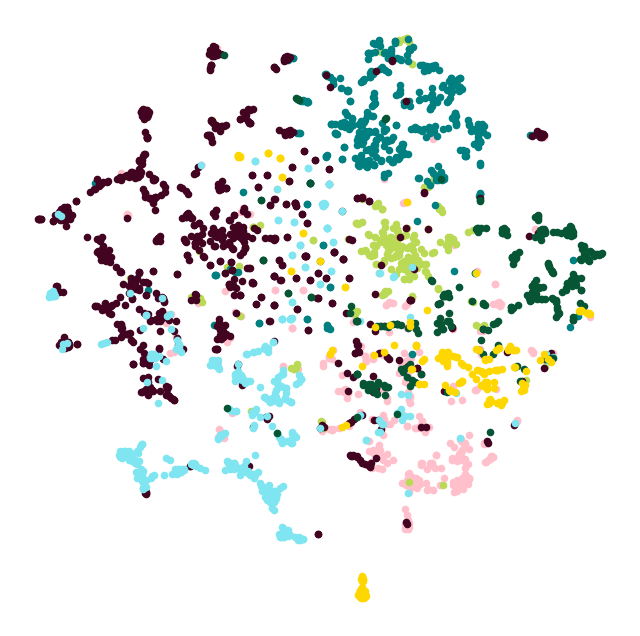

In [18]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    # votre code ici

    # Récupérer les embeddings du modèle Node2Vec
    z = model.forward().cpu()

    # Application de TSNE sur les embeddings
    # z_2d = TSNE(n_components=2, random_state=42).fit_transform(z.numpy())
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()


    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

# Downstream Task : Classification

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
model.eval()
# recuperer les plognements et les labels, transformez les en numpy arrays

emb = model()

#X = ...............
#Y = ...............
X = emb.detach().cpu().numpy()
Y = data.y.cpu().numpy()


# Split data 0.9 entrainement et 0.1  test (votre code ici) : utilisez sklearn.model_selection.train_test_split
# X_train, X_test, Y_train, Y_test = ...................
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
    )
)


## Entrainez votre classificateur

Utilisez le classificateur : la régression logistique

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Votre code ici
clf = LogisticRegressionCV(
    cv=5,
    max_iter=500,
    multi_class='multinomial',
    random_state=42
).fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Prédire les classes des noeuds de test

In [21]:
# Votre code ici
Y_pred = clf.predict(X_test)

## Calculer l'accuracy de votre classificateur

In [23]:
# Votre code ici
accuracy = accuracy_score(Y_test, Y_pred)

print("Accuracy :", accuracy)

Accuracy : 0.8302583025830258
